# CLUSTERING-Kmeans,Hierarchical,DBSCAN

## Amazon Fine Food Reviews 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, forming clusters and going through them whether they are correctly gathered or not.



In [1]:
#importing all the packages that are required
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer




con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)

# K-MEANS CLUSTERING

## text preprocessing 

In [2]:
s1= filtered_data.loc[filtered_data["Score"]>=4].sample(n=17500,random_state=1)
print(s1.shape)

s2= filtered_data.loc[filtered_data["Score"]<=2].sample(n=14500,random_state=127)
print(s2.shape)
data=s1
data=data.append(s2)
data.shape
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
data['Score'] = positiveNegative

(17500, 10)
(14500, 10)


In [24]:
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final=final.drop_duplicates(subset={"UserId","ProfileName","Time"},keep='first',inplace=False)
final.shape
final['Score'].value_counts()

positive    3461
negative    1467
Name: Score, dtype: int64

In [25]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english') 

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 

    str1 = b" ".join(filtered_sentence)
    
    final_string.append(str1)
    i+=1

0
Though they might be a bit pricey for just the average dog owner like myself (as opposed to say someone in a profession working with dogs), they're great treats.<br />Perfect size for the quick little snack on the run.<br />And yeah... my dog loves these. At 13, she's getting pretty finicky, and these will gather her full attention.<br />Recommended.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
final=final.sort_values('Time')
x= np.array(final['Text'])

## K-Means On Bag Of Words

In [7]:
count_vect = CountVectorizer()
final_bow = count_vect.fit_transform(x)

In [8]:
from sklearn.cluster import KMeans

In [12]:
scores =[]
mylist = list(range(2,10,2))
for i in mylist:
    kmeans = KMeans(n_clusters=i).fit(final_bow)
    labels=kmeans.inertia_
    scores.append(labels)



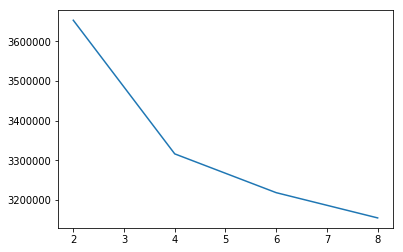

In [13]:
plt.plot(mylist, scores)
#elbow-method Graph

In [9]:
kmeans = KMeans(n_clusters=7).fit(final_bow)
final['cluster_bow']=kmeans.labels_
sets=pd.concat([final[['Text','cluster_bow']]])
sets.head(5)


,Text,cluster_bow
138017,"These are easy to use, they do not make a mess...",4
212471,"Many movies, have dealt with the figure of dea...",6
346037,I am continually amazed at the shoddy treatmen...,1
212530,"Set in a small New England town, Tim Burton's ...",3
346053,Simply put: Beetlejuice is the funniest comedy...,4


In [10]:
s1=sets[sets['cluster_bow']==1]
s1.head(5)

,Text,cluster_bow
346037,I am continually amazed at the shoddy treatmen...,1
195834,The plant is very healthy. It arrived quickly ...,1
58199,I HAVE BOUGHT THREE BOTTLES OF THIS PRODUCT. I...,1
148254,"We originally bought this for Sadie, our 75-po...",1
497786,I love V8. It looks and tastes mostly like to...,1


In [11]:
s2=sets[sets['cluster_bow']==0]
s2.head(5)

,Text,cluster_bow
307803,They seem a bit smaller than they were a few y...,0
376847,"Loved the name, loved the concept. I tried thi...",0
106077,"Yes, ALL Wrigley's Gums, even the ones with SU...",0
443323,I had read about these noodles in Your Diet ma...,0
234556,"Being a mustard affectianco, for lo these 60 b...",0


### Word Clouds 

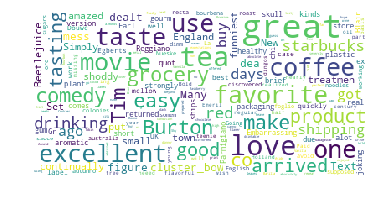

In [14]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(sets))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

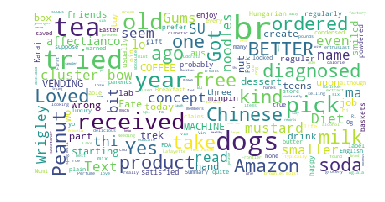

In [15]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(s2))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

### For tfidf 

In [17]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(x)
final_tf_idf.get_shape()

(29167, 575477)

In [18]:
scores =[]
mylist = list(range(2,40,2))
for i in mylist:
    kmeans = KMeans(n_clusters=i).fit(final_tf_idf)
    labels=kmeans.inertia_
    scores.append(labels)



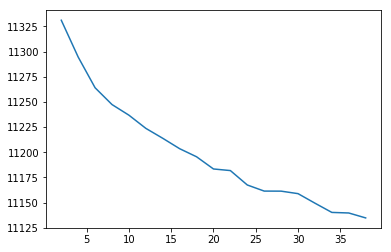

In [32]:
plt.plot(mylist,scores)

In [18]:
kmeans = KMeans(n_clusters=34).fit(final_tf_idf)

In [19]:
final['cluster_tfidf']=kmeans.labels_
sets1=pd.concat([final[['Text','cluster_tfidf']]])
sets1.head(5)
# taking sets which has a review text and its cluster-label

,Text,cluster_tfidf
138017,"These are easy to use, they do not make a mess...",10
212471,"Many movies, have dealt with the figure of dea...",27
346037,I am continually amazed at the shoddy treatmen...,18
212530,"Set in a small New England town, Tim Burton's ...",18
346053,Simply put: Beetlejuice is the funniest comedy...,18


In [20]:
ts0=sets1[sets1['cluster_tfidf']==0]
ts0.head(5)

,Text,cluster_tfidf
92718,This soup is really delicious if you add 8oz. ...,0
9176,I did not enjoy this soup; I will try a differ...,0
282947,"Perhaps it was just my microwave, or cooking i...",0
405200,This is the best instant soup ever!! I have e...,0
7192,"In court, as I understand it, you're not suppo...",0


### Word cloud 

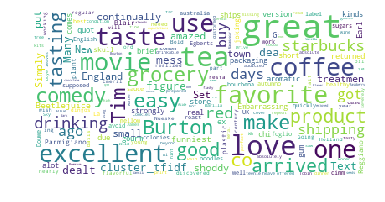

In [21]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(sets1))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

# CONCLUSION for kmeans clustering:
- I have taken about 33 clusters and I have read some of them.
- Considering cluster-0 it has data which resembles to great,coffee,love,tea,grocery.
- I have also gone through the cluster-1 it has data about gluten-free bread,bakery and milk item like almond milk.
- from cluster-4 I would conclude that it contains data related healthy items,tea,coffee and other fruits.
- from cluster-5 I would say that it consists of food that is tasty and perfectly made.
- from cluster-3 I can make out it has mostly about plants,healthy food.
- from cluster-6 It has a lot of data that is related to disease or health issues.

In [62]:
x = PrettyTable()

x.field_names = ["Cluster", "common words"]

x.add_row(["cluster-0","grocery,love,great"])
x.add_row(["cluster-1","bread,milk"])
x.add_row(["cluster-3","plants and healthy food"])
x.add_row(["cluster-4","fruits,tea"])
x.add_row(["cluster-5","perfect and tasty"])
x.add_row(["cluster-6","health and disease"])
#cluster-2 contains a mix of different words that cannot be classified
print(x)

+-----------+-------------------------+
|  Cluster  |       common words      |
+-----------+-------------------------+
| cluster-0 |    grocery,love,great   |
| cluster-1 |        bread,milk       |
| cluster-3 | plants and healthy food |
| cluster-4 |        fruits,tea       |
| cluster-5 |    perfect and tasty    |
| cluster-6 |    health and disease   |
+-----------+-------------------------+


# HIERARCHICAL CLUSTERING 

As mentioned in the assignment taking just a sample since its time complexity is very large.

In [22]:
s1= filtered_data.loc[filtered_data["Score"]>=4].sample(n=3500,random_state=1)
print(s1.shape)

s2= filtered_data.loc[filtered_data["Score"]<=2].sample(n=1500,random_state=127)
print(s2.shape)
data=s1
data=data.append(s2)
data.shape
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
data['Score'] = positiveNegative

(3500, 10)
(1500, 10)


In [27]:
count_vect = CountVectorizer()
final_bow = count_vect.fit_transform(x)
final_bow.shape
xhc=final_bow.toarray()

In [28]:
from sklearn.cluster import AgglomerativeClustering

In [12]:
model=AgglomerativeClustering()
model.fit(xhc)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000002F257081510>)

In [17]:
final['hclusters']=model.labels_
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText', 'hclusters'],
      dtype='object')

## applying for 5 clusters on bag of words

In [29]:
model=AgglomerativeClustering(n_clusters=5)
model.fit(xhc)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x000001E4032D68C8>)

In [30]:
final['hclusters']=model.labels_
sets2=pd.concat([final[['Text','hclusters']]])
sets2.head(10)
#taking the cluster label and the text combination in forms of sets

,Text,hclusters
37320,Are you supposed to avoid sugars if you have a...,4
417920,This is one of the movies you will neeed to se...,4
417910,This has been my favorite movie since I was a ...,4
99127,For the politically correct or incorrect which...,2
132748,I buy mine from Sams Club! They are so good! J...,4
497786,I love V8. It looks and tastes mostly like to...,1
82098,"I was a little concerned to buy the popcorn, a...",2
386768,The shipping was super quick and the tree was ...,2
504134,The brittle was a present for my father - his ...,2
191425,I wouldn't recommend this deck since it is car...,4


In [37]:
s3=sets2[sets2['hclusters']==2]
s3.head(10)

,Text,hclusters
99127,For the politically correct or incorrect which...,2
82098,"I was a little concerned to buy the popcorn, a...",2
386768,The shipping was super quick and the tree was ...,2
504134,The brittle was a present for my father - his ...,2
297367,The Everlasting Treat Ball is a great way to k...,2
123080,I was amazed that I found out these have been ...,2
46886,"I just discovered Barry Farms rice, including ...",2
301773,"I have tried many a rooibois, and this one top...",2
232517,Although I've had better buffalo jerkey this s...,2
212972,The biggest pain to making authentic hummus fr...,2


### Word cloud

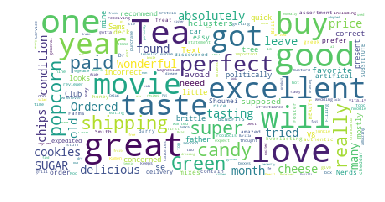

In [38]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(sets2))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

## Observation of Bow:
- considering cluster-3 it mostly consists of protein(dog food),coffee(cold-coffee) and also about some criticism on the recieved product.
- from cluster-4 the data mostly contains about food or order which was perfect,tasty and fruits.
- from cluster-2 the data mostly contains about food which is extraordinary and perfect.
- from cluster-1 the data mostly contains about junk food,cheese,dairy and bakery products.
- from cluster-0 the data mostly contains about food that may be recommended as healthy and allergies.






In [61]:
x = PrettyTable()

x.field_names = ["Cluster", "common words"]

x.add_row(["cluster-0","healthy and allergies"])
x.add_row(["cluster-1","junk food and dairy/bakery products"])
x.add_row(["cluster-2","perfect"])
x.add_row(["cluster-3","protein,coffee"])
x.add_row(["cluster-4","fruits and tasty"])

print(x)

+-----------+-------------------------------------+
|  Cluster  |             common words            |
+-----------+-------------------------------------+
| cluster-0 |        healthy and allergies        |
| cluster-1 | junk food and dairy/bakery products |
| cluster-2 |               perfect               |
| cluster-3 |            protein,coffee           |
| cluster-4 |           fruits and tasty          |
+-----------+-------------------------------------+


## HIERARCHICAL CLUSTERING ON TFIDF

In [39]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x)
final_tf_idf.get_shape()
tf=final_tf_idf.toarray()
model=AgglomerativeClustering(n_clusters=2)
model.fit(tf)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000001E4032D68C8>)

In [40]:
final['hclusters']=model.labels_
sets3=pd.concat([final[['Text','hclusters']]])
sets3.head(5)


,Text,hclusters
37320,Are you supposed to avoid sugars if you have a...,1
417920,This is one of the movies you will neeed to se...,1
417910,This has been my favorite movie since I was a ...,1
99127,For the politically correct or incorrect which...,1
132748,I buy mine from Sams Club! They are so good! J...,1


### Word cloud

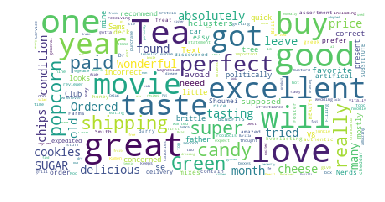

In [41]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(sets3))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

## Observation:
- here from cluster 0 we can say that it mostly contains positive words such as amazed,favourite,perfect.
- from cluster-1 the data mostly contains about coffee,tea,food items and their taste.

In [60]:
from ipywidgets import *
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Cluster", "common words"]

x.add_row(["cluster-0","amazed,favourite,perfect"])
x.add_row(["cluster-1","sugar,tea,coffee"])

print(x)

+-----------+--------------------------+
|  Cluster  |       common words       |
+-----------+--------------------------+
| cluster-0 | amazed,favourite,perfect |
| cluster-1 |     sugar,tea,coffee     |
+-----------+--------------------------+


# DBSCAN Clustering

## DBSCAN on AVG-W2VEC

In [42]:
import warnings
warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim
i=0
list_of_sent=[]
for sent in x:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    

words = list(w2v_model.wv.vocab)
print(len(words))

avg_w2v = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    avg_w2v.append(sent_vec)
print(len(avg_w2v))
print(len(avg_w2v[0]))

4348
4928
50


In [43]:
from sklearn.cluster import DBSCAN

In [44]:
model=DBSCAN(eps=0.5,min_samples=200).fit(avg_w2v)    

In [45]:
from sklearn.neighbors import NearestNeighbors
d=NearestNeighbors(n_neighbors=200,metric='euclidean')
#getting the 200th nearest neighbor and finding the distance by using NearestNeighbors

In [46]:
d.fit(avg_w2v)
#fitting the vector into the model to find the distances

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=200, p=2, radius=1.0)

In [47]:
dist,index=d.kneighbors(avg_w2v)
distances=dist[:,-1]

In [48]:
distances.sort()
#sorting the distances 

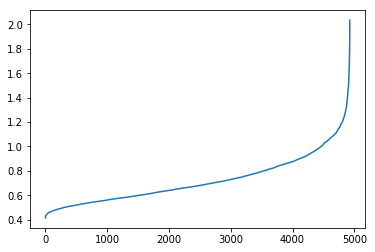

In [49]:
plt.plot(distances)

In [50]:
final['hclusters']=model.labels_
sets4=pd.concat([final[['Text','hclusters']]])
sets4.columns
sets4.head(10)

,Text,hclusters
37320,Are you supposed to avoid sugars if you have a...,-1
417920,This is one of the movies you will neeed to se...,0
417910,This has been my favorite movie since I was a ...,-1
99127,For the politically correct or incorrect which...,0
132748,I buy mine from Sams Club! They are so good! J...,-1
497786,I love V8. It looks and tastes mostly like to...,0
82098,"I was a little concerned to buy the popcorn, a...",-1
386768,The shipping was super quick and the tree was ...,0
504134,The brittle was a present for my father - his ...,-1
191425,I wouldn't recommend this deck since it is car...,-1


### Word cloud 

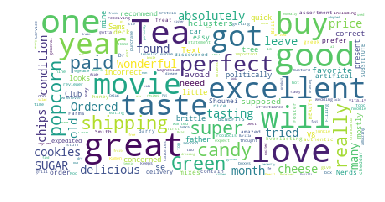

In [51]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(sets4))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

## DBSCAN on TFIDF-W2VEC 

In [52]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x)


tfidf_feat = tf_idf_vect.get_feature_names() 

tfidf_sent_vectors = []; 
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
     
    

In [53]:
model=DBSCAN(eps=0.5,min_samples=200).fit(tfidf_sent_vectors)    
from sklearn.neighbors import NearestNeighbors
d=NearestNeighbors(n_neighbors=200,metric='euclidean')
#getting the 200th nearest neighbor and finding the distance by using NearestNeighbors

In [54]:
d.fit(avg_w2v)
#fitting the vector into the model to find the distances

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=200, p=2, radius=1.0)

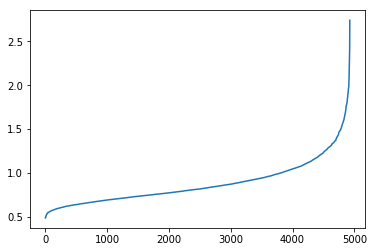

In [55]:
#plotting the distances graph
dist,index=d.kneighbors(tfidf_sent_vectors)
distances=dist[:,-1]
distances.sort()
plt.plot(distances)

In [56]:
final['hclusters']=model.labels_
sets5=pd.concat([final[['Text','hclusters']]])
sets5.columns
sets5.head(10)

,Text,hclusters
37320,Are you supposed to avoid sugars if you have a...,-1
417920,This is one of the movies you will neeed to se...,-1
417910,This has been my favorite movie since I was a ...,-1
99127,For the politically correct or incorrect which...,-1
132748,I buy mine from Sams Club! They are so good! J...,-1
497786,I love V8. It looks and tastes mostly like to...,-1
82098,"I was a little concerned to buy the popcorn, a...",-1
386768,The shipping was super quick and the tree was ...,-1
504134,The brittle was a present for my father - his ...,-1
191425,I wouldn't recommend this deck since it is car...,-1


### word cloud


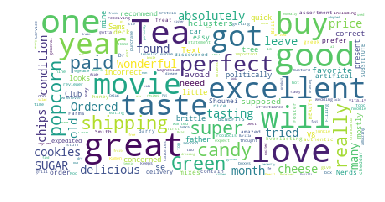

In [57]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(sets5))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

# CONCLUSION:
- from above DBSCAN models we got the graphs which satisfy the property.
- from the clusters we could see some of the key words such as good,amazed,easy which are all defining that the cluster would be 
 a positive reviews cluster.
- considering both TFIDF word2Vec and AVGword2Vec there not much of a difference in the cluster formation because when we consider them in a graph whether it may be tfidf or average they basically are a word2vec form and take minpts as 200. So the nearest distance that it takes is from the 200th point.
- I have taken Word2Vec vectorizers because Here we have to deal with dimensions so taking a word2vec whose dimension is within a reach or not that huge value makes it more effective to work on finding the densities of the clusters.
